In [594]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import binomtest, ttest_ind, chi2_contingency, f_oneway, chisquare, ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

train_set = pd.read_csv("train_data.csv")
train_set.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [595]:
train_set["Exited"].value_counts()

Exited
0    113129
1     30450
Name: count, dtype: int64

On voit que les deux classes de la target sont assez désiquilibré et c'est pour cette raison qu'on utilisera la métrique f1_score.

#I) Définition des variables et des lignes

•   Customer ID : Un identifiant unique pour chaque client (discret)

•   Surname : Le nom de famille du client (discret)

•   Credit Score : Une valeur numérique représentant le score de crédit du client (continue)

•   Geography : Le pays où réside le client (France, Spain ou Germany) (discret)

•   Gender : Le genre du client (Male or Female) (discret)

•   Age : L’âge du client (C'est une variable discréte mais qu'on va traiter comme une variable continue)

•   Tenure : Le nombre d’années pendant lesquelles le client est avec la banque (discret)

•   Balance : Le solde du compte du client (continue)

•   NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d’épargne, carte de crédit) (discret)

•   HasCrCard : Si le client possède une carte de crédit (1 = oui, 0 = non) (discret)

•   IsActiveMember : Si le client est un membre actif (1 = oui, 0 = non) (discret)

•   EstimatedSalary : Le salaire estimé du client (continue)

•   Exited : Si le client a résilié (1 = oui, 0 = non) (discret)

•   Pour la définition des lignes, c'est les clients.

#II) Analyse statistiques

#II.1) Analyse univarié de toutes les variables ainsi que l'analyse bivarié de toutes les variables avec la target

#II.1.1) Analyse du score de crédit.

#II.1.1.a) Analyse univarié

Le score de crédit est un indicateur de la capacité d'un client de payer ces dettes. Plus ce score est bas, plus le client n'est pas fiable. L'échelle et l'interprétation de ce score dépends du pays mais aussi de la banque.

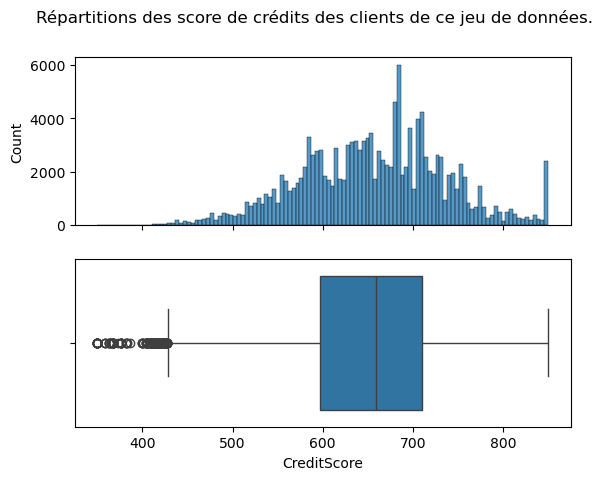

count    143579.000000
mean        656.411704
std          80.210361
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
Name: CreditScore, dtype: float64

In [596]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des score de crédits des clients de ce jeu de données.")
sns.histplot(data=train_set, x="CreditScore", ax=ax[0])
sns.boxplot(data=train_set, x="CreditScore", ax=ax[1])
plt.show()
train_set["CreditScore"].describe()

On observe que la moyenne des clients qui vive en France, Allemagne et Espagne est d'environ 656. On observe que les score de crédit suive clairement une loi normale. On observe quelque outliers à gauche de la boxplot qui correspond donc au client les moins fiables. On voit aussi que la plupart des clients ont un crédit de score entre 580 et 750. C'est-à-dire que la plupart des clients ont un score de crédit plutôt moyen.

#II.1.1.b) Analyse du crédit de score par rapport à la target

On va comparer les moyennes et les répartitions du score de crédit pour les clients qui ont résilié et ceux qui n'ont pas résilié.

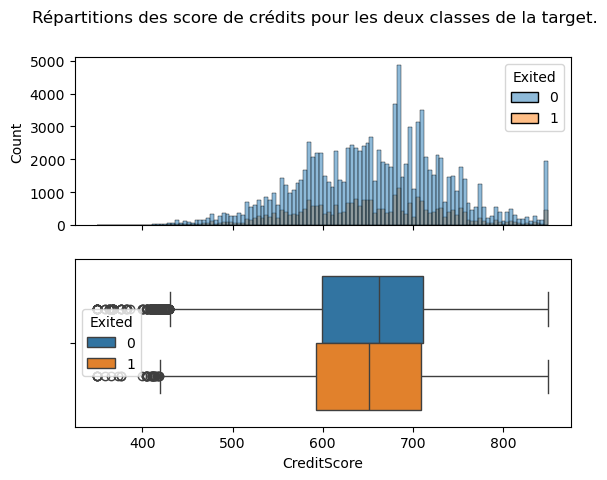

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,657.532136,79.899437,350.0,599.0,662.0,711.0,850.0
1,30450.0,652.249031,81.221163,350.0,593.0,651.0,709.0,850.0


In [597]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des score de crédits pour les deux classes de la target.")
sns.histplot(data=train_set, x="CreditScore", hue="Exited", ax=ax[0])
sns.boxplot(data=train_set, x="CreditScore", hue="Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["CreditScore"].describe()

On observe qu'il y a une superposition des histogrammes mais on observe que la médiane ainsi que la moyennes des scores de crédit des clients qui ont résilié sont inférieur à ceux qui n'ont pas résilié ainsi que à la moyenne générale de 656 observer précédemment. On voit que pour le cas des clients qui n'ont pas résilié, leurs moyennes est tréslégéremment supérieur à la moyennes observer de la totalité du jeu de donnée. On voit des outliers à gauche des boxplots. Maintenant, on peut essayer de faire trois test, un pour vérifier si la moyenne des score de crédits des clients qui ont résilié est effectivement inférieur à la valeur de 656 ainsi que inférieur à la moyenne du score de crédit des clients qui n'ont pas résilié. On va d'abors vérifié les conditions d'utilisation. Le score de crédit d'un client ne dépends pas des autres, tous les clients sont issues de la même banque, les deux classes ont plus de 30 points chacun et les variances des deux classes sont assez proche pour utiliser le test de student.

In [598]:
print("H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à ceux des clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Exited` == 1")["CreditScore"], train_set.query("`Exited` == 0")["CreditScore"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à ceux des clients qui n'ont pas résilié.
Nous avons assez d'évidence pour rejeter H0


Comme on a assez d'évidence pour rejeter H0, on peut dire avec 2% de risque de ce trompé que le score de crédit moyens des clients qui ont résilié est bien inférieur à celui des clients qui n'ont pas résilié.

In [599]:
print("H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à la moyenne du score de crédit totale.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 1")["CreditScore"], train_set["CreditScore"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à la moyenne du score de crédit totale.
Nous avons assez d'évidence pour rejeter H0


Comme on a assez d'évidence pour rejeter H0, on peut dire avec 2% de risque de ce trompé que le score de crédit moyens des clients qui ont résilié est bien inférieur à la moyenne du score de crédit totale (656).

In [600]:
print("H0: Les clients qui n'ont pas résilié ont en moyenne un score de crédit égale à la moyenne du score de crédit totale.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 0")["CreditScore"], train_set["CreditScore"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui n'ont pas résilié ont en moyenne un score de crédit égale à la moyenne du score de crédit totale.
Nous avons assez d'évidence pour rejeter H0


Comme on a assez d'évidence pour rejeter H0, on peut dire avec 2% de risque de ce trompé que le score de crédit moyens des clients qui n'ont pas résilié est bien supérieur à la moyenne du score de crédit totale (656). On peut en conclure que les clients qui ont résilié sont en moyenne moins fiable que les clients qui n'ont pas résilié et que les clients qui ont résilié sont en moyenne significativement moins fiable que la moyenne de la totalité des clients de la banque. On peut aussi dire que les clients qui n'ont pas résilié sont en moyenne plus fiable que les clients qui ont résilié et en moyenne plus fiable que la moyenne de la totalité des clients de la banque. Il y a donc une influence entre le score de crédit et la target malgré une superposition totale des histogrammes.

#II.1.2) Analyse du pays de résidence

#II.1.2.a) Analyse univarié

On va d'abord compter le nombre de client par pays de résidence.  

In [601]:
train_set["Geography"].value_counts()

Geography
France     81886
Spain      31588
Germany    30105
Name: count, dtype: int64

On voit que la plupart des clients vive en France. Ensuite il y a un nombre similaire de client qui vive en Espagne et en Allemagne avec légéremment plus de client en Espagne qu'en Allemagne.

#II.1.2.b) Analyse de geography en fonction de la target

In [602]:
pd.crosstab(train_set["Geography"], train_set["Exited"])

Exited,0,1
Geography,,
France,68338,13548
Germany,18657,11448
Spain,26134,5454


On voit que dans les deux cas, il y a plus de clients qui vivent en France. Ensuite on voit qu'il y a parmis les clients qui ont résilié plus de clients qui vive en Allemagne qu'en Espagne et c'est l'inverse pour les clients qui n'ont pas résilié. Maintenant testons si il y a bien une corrélation ente le pays de résidence et la target.

In [603]:
print("H0: Il n'y a pas de relation entre le pays de résidence et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Geography"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le pays de résidence et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut donc dire avec un risque de ce trompé de 2% qu'il y a bien une relation entre le pays de résidence et la target.

#II.1.3) Analyse du genre

#II.1.3.a) Analyse univarié

In [604]:
train_set["Gender"].value_counts()

Gender
Male      80966
Female    62613
Name: count, dtype: int64

On voit qu'il y a plus d'homme que de femme dans cette banque.

#II.1.3.b) Analyse du genre par rapport à la target

In [605]:
pd.crosstab(train_set["Gender"], train_set["Exited"])

Exited,0,1
Gender,,
Female,45038,17575
Male,68091,12875


On voit qu'il y a plus de femme que d'hommes parmis les clients qui résilie et c'est l'inverse pour ceux qui ne résilie pas. On va maintenant tester si il y a bien une relation entre le genre et la target.

In [606]:
print("H0: Il n'y a pas de relation entre le genre et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Gender"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le genre et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut donc dire avec un risque de se trompé de 2% qu'il y a bien une relation entre le genre et la target.

#II.1.4) Analyse de l'âge

#II.1.4.a) Analyse univarié

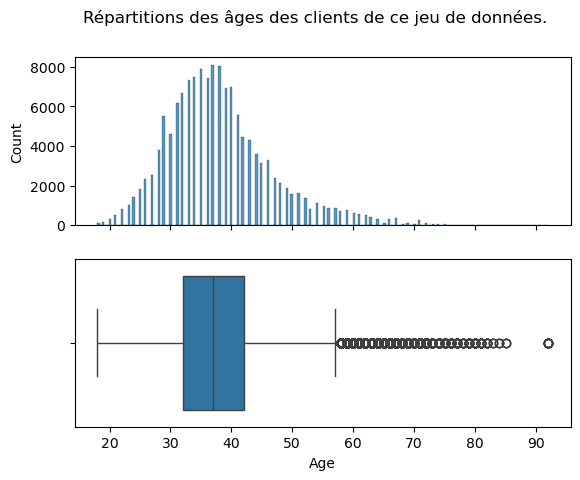

count    143579.000000
mean         38.144476
std           8.871711
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

In [607]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des âges des clients de ce jeu de données.")
sns.histplot(data=train_set, x="Age", ax=ax[0])
sns.boxplot(data=train_set, x="Age", ax=ax[1])
plt.show()
train_set["Age"].describe()

On voit que la moyenne d'âge des clients de la banque qui vivent en France, Allemagne et Espagne est de 38 ans. On voit que l'âge suit une loi normale et il y a des outliers à droite de la boxplot. On voit que la plupart des clients ont entre 30 et 40 ans.

#II.1.4.b) Analyse de l'âge en fonction de la target

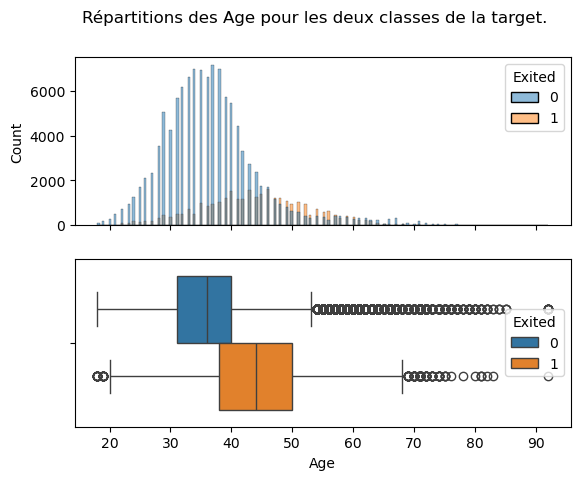

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,36.583765,8.166737,18.0,31.0,36.0,40.0,92.0
1,30450.0,43.942890,8.981339,18.0,38.0,44.0,50.0,92.0


In [608]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des Age pour les deux classes de la target.")
sns.histplot(data=train_set, x="Age", hue="Exited", ax=ax[0])
sns.boxplot(data=train_set, x="Age", hue="Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["Age"].describe()

On observe qu'il y a une zone entre 48 ans et 55 ans dans lequel il y a plus de clients qui ont résilié que de client qui n'ont pas résilié. On observe que les deux boxplot sont relativement différent et on observe que l'âge moyens des clients qui ont résilié est plus grands que la moyenne des clients qui n'ont pas résilié et plus grand que la moyenne de l'âge pour la totalité du dataset. On observe aussi que l'âge moyens des clients qui n'ont pas résilié est plus petit que la moyenne des clients qui ont résilié et plus petit que la moyenne de l'âge pour la totalité du dataset. On observe des outliers à droite des deux boxplot. On voit que la boxplot des clients qui n'ont pas résilié est moins étendues que la boxplot des clients qui ont résilié. On observe quelques outliers à gauche de la boxplot des clients qui ont résilié. On voit aussi que les deux histogramme sont des lois normale et que l'histogramme des clients qui ont résilié est décalé par rapport à l'autre histogramme. On a un début de séparation avec cette variable. On va faire un test de student et on va d'abords regarder les conditions d'utilisation. L'âge d'un client ne dépend pas des autres, tous les clients sont issues de la même population, il y a plus de 30 points par classes et les variances sont approximativement identiques. On peut utiliser un test de student.

In [609]:
print("H0: Les clients qui ont résilié ont en moyenne le même âge que les clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Exited` == 1")["Age"], train_set.query("`Exited` == 0")["Age"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne le même âge que les clients qui n'ont pas résilié.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut en conclure avec un risque de se trompé de 2% que les clients qui ont résilié sont en moyenne plus âgé que les clients qui n'ont pas résilié. On va maintenant comparer les deux moyennes en fonction de la moyenne de la totalité des clients.

In [610]:
print("H0: Les clients qui ont résilié ont un âge moyen égale à la moyenne calculer à partir de la totalité du dataset.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 1")["Age"], train_set["Age"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont un âge moyen égale à la moyenne calculer à partir de la totalité du dataset.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut en conclure avec un risque de se trompé de 2% que l'âge moyen des clients qui ont résilié est supérieur à l'âge moyen de tous les clients.

In [611]:
print("H0: Les clients qui ont résilié ont un âge moyen égale à la moyenne calculer à partir de la totalité du dataset.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 0")["Age"], train_set["Age"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont un âge moyen égale à la moyenne calculer à partir de la totalité du dataset.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut en conclure avec un risque de se trompé de 2% que l'âge moyen des clients qui n'ont pas résilié est inférieur à l'âge moyen de tous les clients. On peut en conclure que les clients qui ont résilié sont plus âgé que les clients qui n'ont pas résilié et que l'âge à bien une influence significatif sur la target.

#II.1.5) Analyse de la tenure

#II.1.5.a) Analyse univarié

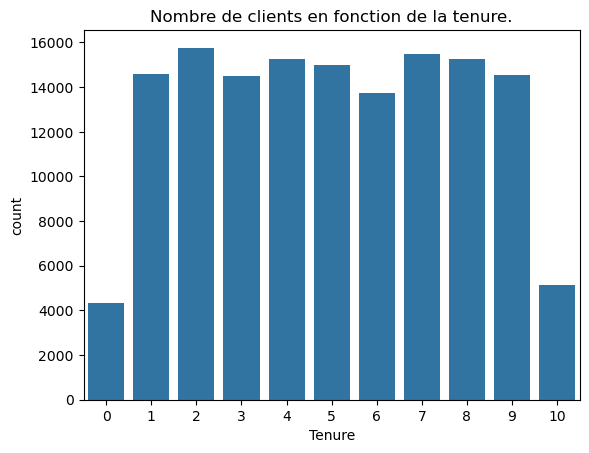

In [612]:
sns.countplot(data=train_set, x="Tenure")
plt.title("Nombre de clients en fonction de la tenure.")
plt.show()

On voit que dans la premiére année de cette banque (Tenure = 10), il y avait une quantité de client qui étais assez petites. Ensuite durant la deuxiéme (Tenure = 9), il y avait une grosse augmentation de la fréquentation de la banque et ensuite la fréquentation est relativement constante entre la deuxiéme année et la dixiéme année (Tenure = 1). Et ensuite durant l'année en cours il y a une diminution du nombre de client. Cela veut dire soit que la banque est moins attractive ou c'est tous simplement due au fait que l'année est en cours.

#II.1.5.b) Analyse de la tenure par rapport à la target

In [613]:
pd.crosstab(train_set["Tenure"], train_set["Exited"])

Exited,0,1
Tenure,,
0,3234,1112
1,11281,3322
2,12692,3074
3,11171,3313
4,11787,3470
5,11685,3299
6,11010,2706
7,12560,2914
8,12221,3051


Il y a toujours plus de clients qui n'ont pas résilié que ceux qui ont résilié. On voit qu'il y a entre les tenures 1 et 2 une diminution des clients qui ont résilié et une augmentation pour les clients qui n'ont pas résilié. Entre une tenure de 2 et 3, on observe une augmentation des clients qui ont résilié et une diminution pour les clients qui n'ont pas résilié. Entre une tenure de 7 et 9, on a une augmentation des clients qui ont résilié et une diminution des clients qui n'ont pas résilié. Il y a donc une influence de la tenure sur la target.

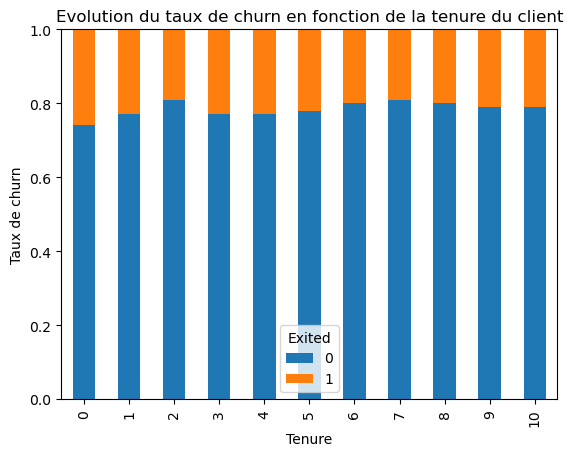

In [614]:
pd.crosstab(train_set["Tenure"], train_set["Exited"], normalize="index").round(2).plot(kind="bar", stacked=True)
plt.title("Evolution du taux de churn en fonction de la tenure du client")
plt.ylabel("Taux de churn")
plt.ylim(0, 1)
plt.show()

On voit que le taux de churn reste constant en fonction de la tenure et par conséquent il n'y a pas d'influence visible de la tenure sur la target. On va quand même faire un test d'hypothése.

In [615]:
print("H0: Il n'y a pas de relation entre la tenure et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Tenure"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre la tenure et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, On peut dire avec un risque de se tromper de 2% qu'il y a bien une relation entre la Tenure et la target.

#II.1.6) Balance

#II.1.6.a) Analyse univarié

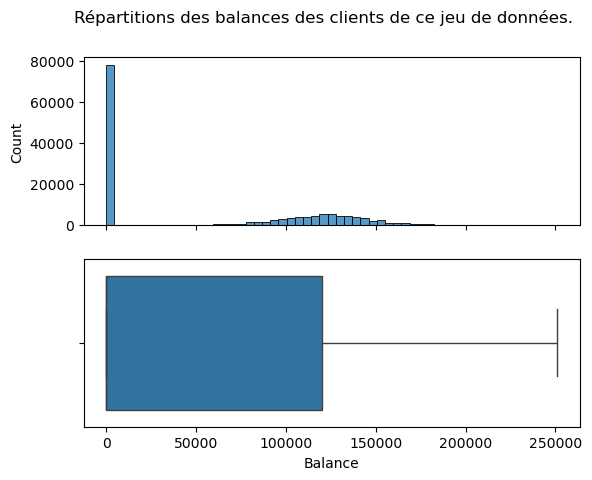

count    143579.000000
mean      55533.640642
std       62822.616346
min           0.000000
25%           0.000000
50%           0.000000
75%      119948.090000
max      250898.090000
Name: Balance, dtype: float64

In [616]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données.")
sns.histplot(data=train_set, x="Balance", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", ax=ax[1])
plt.show()
train_set["Balance"].describe()

On voit que la plupart des clients ont une balance égale à 0. On voit qu'il y a une loi normale séparer des balances égales à 0. Pas d'outliers sur la boxplot. La moyenne de la balance des clients de cette banque pour les trois pays du jeu de données est d'environ 55728.70 euros.

#II.1.6.b) Analyse de la balance par rapport à la target

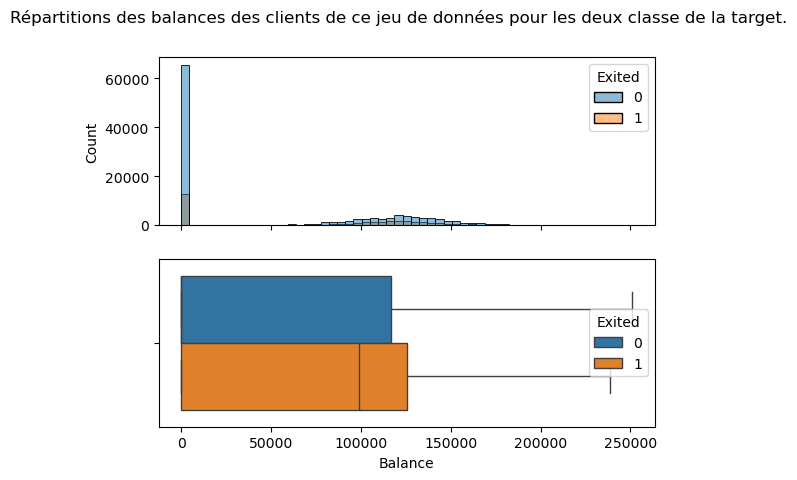

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,51274.230558,62196.885812,0.0,0.0,0.00,116811.12,250898.09
1,30450.0,71358.363247,62606.860862,0.0,0.0,98959.19,125521.18,238387.56


In [617]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour les deux classe de la target.")
sns.histplot(data=train_set, x="Balance", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["Balance"].describe()

On voit qu'il n'y a pas de séparation des deux histogrammes mais qu'il y a des différences entre les deux moyennes. On voit que la différence entre nombre de client qui ont une balance égale à 0 et une balance différente de 0 est beaucoup plus grands pour le cas des clients qui n'ont pas résilié ce qui explique pourquoi en moyenne les clients qui n'ont pas résilié ont une moyenne de balance moins élevé que ceux qui ont résilié. Comme cette variable ne suit pas une loi normale, on ne peut pas faire un test de student, on le fera sur les balances différents de 0. Regardons maintenant la loi normale de plus prés.

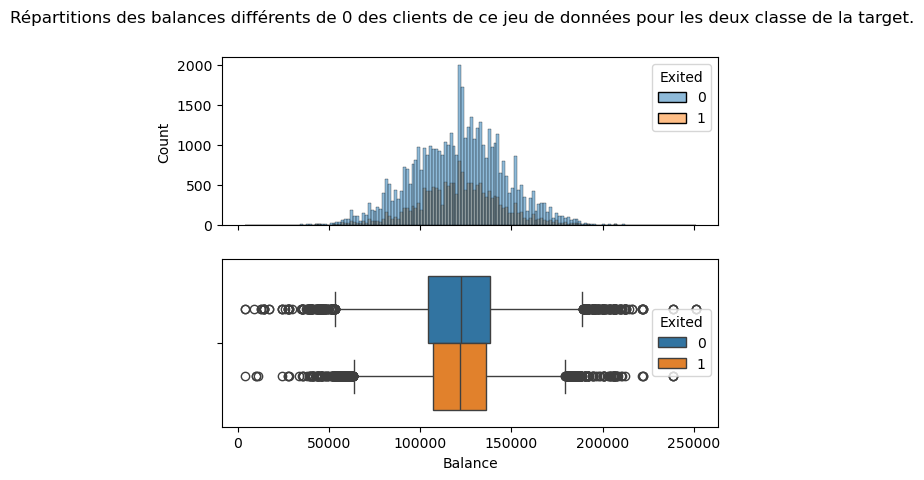

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,47803.0,121343.899521,25541.298733,3768.69,104154.250,122359.50,138023.520,250898.09
1,17858.0,121674.440635,23686.386782,3768.69,106920.255,121874.89,135927.445,238387.56


In [618]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances différents de 0 des clients de ce jeu de données pour les deux classe de la target.")
sns.histplot(data=train_set.query("`Balance` != 0"), x="Balance", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set.query("`Balance` != 0"), x="Balance", hue = "Exited", ax=ax[1])
plt.show()
train_set.query("`Balance` != 0").groupby("Exited")["Balance"].describe()

On voit cette fois-ci des outliers à droite et à gauche des deux boxplot. La boxplot des clients qui ont résilié est moins étendues que pour les clients qui n'ont pas résilié. Les deux moyennes sont similaire mais les écart-type sont différents. On va donc faire un test de student. La balance d'un client ne dépends pas des autres et il y a plus de 30 points par classes et les écart-type sont assez proche pour utiliser le test de student.

In [619]:
print("H0: Les clients qui n'ont pas résilié ont en moyenne la même balance différents de 0 que les clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Balance` != 0 and `Exited` == 0")["Balance"], train_set.query("`Balance` != 0 and `Exited` == 1")["Balance"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui n'ont pas résilié ont en moyenne la même balance différents de 0 que les clients qui n'ont pas résilié.
Nous n'avons pas assez d'évidence pour rejeter H0.


Comme on n'a pas rejeter H0, on peut dire que les deux moyennes pour des balances différents de 0 ne sont pas significativement différentes. On en conclut que l'effet de la balance sur la target sera seulement au différences de nombres de clients entre les balance différent de 0 et égale à 0 pour les deux classes.

#II.1.7) NumOfProducts

#II.1.7.a) Analyse univarié

In [620]:
train_set["NumOfProducts"].value_counts()

NumOfProducts
2    73301
1    67364
3     2510
4      404
Name: count, dtype: int64

On voit que la plupart des clients ont 1 ou 2 produits et qu'il y a vraiment peu de cients qui ont 3 et 4 produit.

#II.1.7.b) Analyse du nombre de produit par rapport à la target

In [621]:
pd.crosstab(train_set["NumOfProducts"], train_set["Exited"])

Exited,0,1
NumOfProducts,,
1,43905,23459
2,68879,4422
3,292,2218
4,53,351


On voit qu'il y a plus de clients qui ont résilié que de client qui 'ont pas résilié parmis les clients qui ont 3 et 4 produits. On voit que parmis les clients qui ont résilié, il y a plus de clients qui ont 1 seul produit que 2 et c'est le contraire pour les clients qui n'ont pas résilié. Il y a donc une influence notable du nombre de produit par rapport à la target. On va faire un test.

In [622]:
print("H0: Il n'y a pas de relation entre le nombre de produit et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["NumOfProducts"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le nombre de produit et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de se trompé de 2% qu'il y a bien une relation entre le nombre de produit et la target.

#II.1.8) HasCrCard

#II.1.8.a) Analyse univarié

In [623]:
train_set["HasCrCard"].value_counts()

HasCrCard
1.0    108274
0.0     35305
Name: count, dtype: int64

On voit que la majorité des clients ont une carte de crédit.

#II.1.8.b) Analyse de HasCrCard par rapport à la target

In [624]:
pd.crosstab(train_set["HasCrCard"], train_set["Exited"])

Exited,0,1
HasCrCard,,
0.0,27246,8059
1.0,85883,22391


In [625]:
pd.crosstab(train_set["HasCrCard"], train_set["Exited"], normalize='index')

Exited,0,1
HasCrCard,,
0.0,0.771732,0.228268
1.0,0.793201,0.206799


On voit que dans les deux classes, il y a plus de clients qui posséde une carte de crédit mais on voit que le taux de churn est plus grand chez les clients qui n'ont pas de carte de crédit et c'est l'inverse pour ceux qui ont une carte de crédit. On va faire un test.

In [626]:
print("H0: Il n'y a pas de relation entre HasCrCard et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["HasCrCard"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre HasCrCard et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de ce trompé de 2% qu'il y a bien une relation entre HasCrCard et la target.

#II.1.9) IsActiveMember

#II.1.9.a) Analyse univarié

In [627]:
train_set["IsActiveMember"].value_counts()

IsActiveMember
0.0    72249
1.0    71330
Name: count, dtype: int64

On voit qu'il y a pratiquement autant de clients actifs que non actif. On peut donc tester cette hypothése.

In [628]:
print("H0: Il y a 50% de clients inactif.")

alpha = 0.02

p_value = binomtest(k=train_set["IsActiveMember"].value_counts()[1], n=len(train_set), p = 0.50).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il y a 50% de clients inactif.
Nous avons assez d'évidence pour rejeter H0


Comme on n'a réussi de rejeter H0, on peut donc dire avec un risque de 2% de se trompé qu'il y a autant de client actif que inactif dans cette banque.

#II.1.9.b) Analyse du status d'activité par rapport à la target 

In [629]:
pd.crosstab(train_set["IsActiveMember"], train_set["Exited"])

Exited,0,1
IsActiveMember,,
0.0,50742,21507
1.0,62387,8943


Parmis les clients qui ont résilié, il y a plus de clients inactif que de client actif et c'est l'inverse pour les clients qui n'ont pas résilié.  On va faire un test.

In [630]:
print("H0: Il n'y a pas de relation entre le status d'activité et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["IsActiveMember"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le status d'activité et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de se trompéde 2% qu'il y a bien une corrélation entre les status d'activité et la target.

#II.1.10) Salaire

#II.1.10.a) Analyse univarié

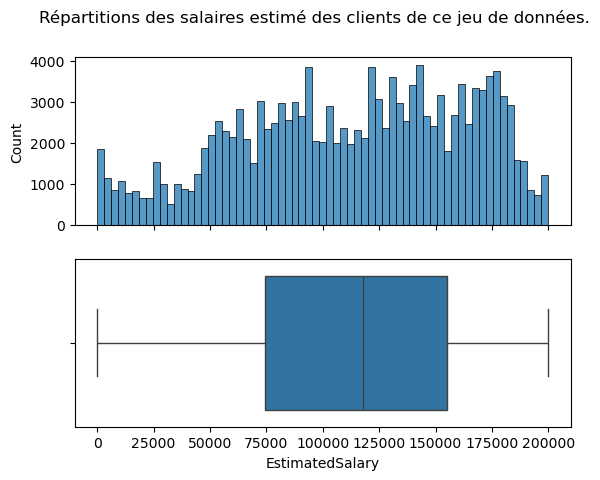

count    143579.000000
mean     112530.072465
std       50301.718378
min          11.580000
25%       74580.800000
50%      117931.100000
75%      155149.685000
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [631]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des salaires estimé des clients de ce jeu de données.")
sns.histplot(data=train_set, x="EstimatedSalary", ax=ax[0])
sns.boxplot(data=train_set, x="EstimatedSalary", ax=ax[1])
plt.show()
train_set["EstimatedSalary"].describe()

On voit que la moyenne des salaires estimé des clients de cette banque est de 112423 euros. Cette variable ne suit pas une loi normale. On observe aussi que le salaire minimum est de 11.58 qui correspond au smic horaire Français (environ égale à 1709 euros). Il faut savoir que les salaires estimé sont généralement des salaires mensuel et à temps plein. On voit que la plupart des salaires sont entre 40000 euros et 180000 euros ce qui est aussi bizarre pour des salaires mensuel. Il y a donc plusieurs types de salaires et par conséquent il faut corriger le salaire.

In [632]:
def correction_salary(df, smic_france, smic_spain, smic_germany):
    conditionlist = [
        
        #Salaire horaire Français
        (df["Geography"] == "France") & (df["EstimatedSalary"] < smic_france) & (df["EstimatedSalary"] * 150.17 < smic_france * 12),
        
        #Salaire horaire Allemand et Espagnol
        ((df["Geography"] == "Spain") & (df["EstimatedSalary"] < smic_spain) & (df["EstimatedSalary"] * 173.33 < smic_spain * 12)) |
        ((df["Geography"] == "Germany") & (df["EstimatedSalary"] < smic_germany) & (df["EstimatedSalary"] * 173.33 < smic_germany * 12)),
        
        #Salaire journalier
        ((df["Geography"] == "France") & (df["EstimatedSalary"] < smic_france) & (df["EstimatedSalary"] * 21.67 < smic_france * 12)) |
        ((df["Geography"] == "Spain") & (df["EstimatedSalary"] < smic_spain) & (df["EstimatedSalary"] * 21.67 < smic_spain * 12)) |
        ((df["Geography"] == "Germany") & (df["EstimatedSalary"] < smic_germany) & (df["EstimatedSalary"] * 21.67 < smic_germany * 12)),
        
        #Salaire hebdomadaire
        ((df["Geography"] == "France") & (df["EstimatedSalary"] < smic_france) & (df["EstimatedSalary"] * 4.33 < smic_france * 12)) |
        ((df["Geography"] == "Spain") & (df["EstimatedSalary"] < smic_spain) & (df["EstimatedSalary"] * 4.33 < smic_spain * 12)) |
        ((df["Geography"] == "Germany") & (df["EstimatedSalary"] < smic_germany) & (df["EstimatedSalary"] * 4.33 < smic_germany * 12)),
        
        #Salaire Annuelle
        ((df["Geography"] == "France") & (df["EstimatedSalary"] >= smic_france * 12)) |
        ((df["Geography"] == "Spain") & (df["EstimatedSalary"] >= smic_spain * 12)) |
        ((df["Geography"] == "Germany") & (df["EstimatedSalary"] >= smic_germany * 12)),
    ]
    choicelist = [150.17, 173.33, 21.67, 4.33, 1/12]
    return np.select(conditionlist, choicelist, default=1)
train_set["Correct_salary"] = train_set["EstimatedSalary"] * correction_salary(train_set, 1709, 1166, 2200)
train_set

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Correct_salary
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0,13433.800833
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0,15118.274167
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0,8405.211667
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1,5097.037500
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0,8644.818333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,97639,15759915,Onwumelu,559,Germany,Male,45.0,3,111634.29,1,1.0,1.0,103349.74,0,8612.478333
143575,95939,15769974,Shih,597,Germany,Male,41.0,10,119182.73,1,0.0,0.0,121299.14,0,10108.261667
143576,152315,15592028,Hsiao,576,Spain,Male,31.0,6,127299.56,1,1.0,1.0,57569.89,0,4797.490833
143577,117952,15804009,Ch'ang,751,France,Female,27.0,4,90721.11,1,0.0,0.0,84496.78,0,7041.398333


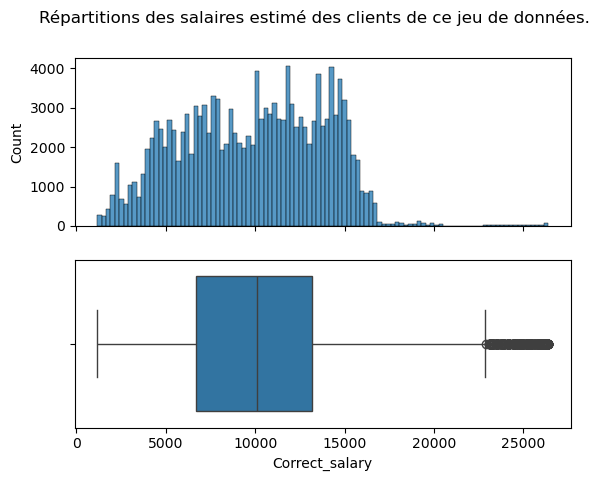

count    143579.000000
mean       9861.014947
std        3951.216644
min        1166.573333
25%        6702.223333
50%       10119.459167
75%       13172.640833
max       26389.920000
Name: Correct_salary, dtype: float64

In [633]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des salaires estimé des clients de ce jeu de données.")
sns.histplot(data=train_set, x="Correct_salary", ax=ax[0])
sns.boxplot(data=train_set, x="Correct_salary", ax=ax[1])
plt.show()
train_set["Correct_salary"].describe()

La moyenne des salaires mensuel estimé des clients de cette banque est de 9845 euros. Cette fois ci on observe des outliers à droite de la boxplot. La variable à une distribution qui ressemble un peu plus à une loi normale. Cette fois-ci la plupart des salaires sont entre 3000 et 15000 euros ce qui est plus probable pour des salaires mensuel.

#II.1.10.b) Analyse du salaire en par rapport à la target

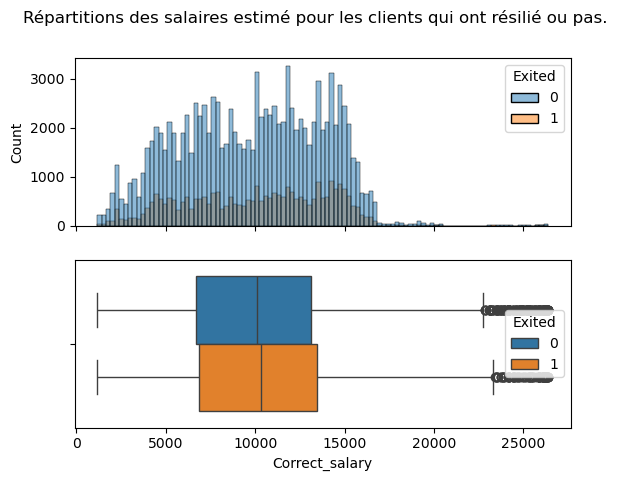

           count          mean          std          min          25%  \
Exited                                                                  
0       113129.0   9807.831810  3938.564425  1166.573333  6666.428333   
1        30450.0  10058.602967  3991.735300  1172.784167  6858.217500   

                 50%           75%       max  
Exited                                        
0       10091.554167  13129.133333  26389.92  
1       10331.893750  13443.894167  26389.92  


In [634]:
fig, ax = plt.subplots(2, 1, sharex="col")
plt.suptitle("Répartitions des salaires estimé pour les clients qui ont résilié ou pas.")
sns.histplot(data=train_set, x="Correct_salary", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set, x="Correct_salary", hue = "Exited", ax=ax[1])
plt.show()
print(train_set.groupby("Exited")["Correct_salary"].describe())

On remarque qu'il n'y a pas du tous de séparation des histogrammes et que les boxplot sont presque les mêmes pour les deux types de salaire. On observe aussi que la moyenne de salaires des clients qui ont résilié est supérieur à celle des clients qui n'ont pas résilié. On va donc garder la version corrigé. On voit que les clients qui résilié ont en moyenne un salaire plus élevé que les clients qui ne résilie pas. On voit que la moyennes de salaires des clients qui ont résilié est supérieur à la moyennes de salaires totales et la moyenne de salaire des clients qui n'ont pas résilié est inférieur à la moyennes de la totalité des clients. On va donc utiliser un test de student. Un salaire ne dépends pas des autres, il y a bien 30 points pour chaque classes et les variances sont assez proches pour faire un test de student.

In [635]:
print("H0: Les clients qui ont résilié ont en moyenne le même salaire que les clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Exited` == 1")["Correct_salary"], train_set.query("`Exited` == 0")["Correct_salary"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne le même salaire que les clients qui n'ont pas résilié.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de 2% de se trompé que le salaire des clients qui ont résilié est bien supérieur à ceux qui n'ont pas résilié.

In [636]:
print("H0: Les clients qui ont résilié ont un salaire moyen égale à la moyenne calculer à partir de la totalité du dataset.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 1")["Correct_salary"], train_set["Correct_salary"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont un salaire moyen égale à la moyenne calculer à partir de la totalité du dataset.
Nous avons assez d'évidence pour rejeter H0


In [637]:
print("H0: Les clients qui n'ont pas résilié ont un salaire moyen égale à la moyenne calculer à partir de la totalité du dataset.")

alpha = 0.02

p_value = ttest_1samp(train_set.query("`Exited` == 0")["Correct_salary"], train_set["Correct_salary"].mean()).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui n'ont pas résilié ont un salaire moyen égale à la moyenne calculer à partir de la totalité du dataset.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0 pour les deux cas, on peut dire avec un risque de 2% de se trompé que les clients qui ont résilié ont en moyenne un salaire supérieur au salaire de la totalité du jeu de données et que les clients qui n'ont pas résilié ont un salaire moyens inférieur à la moyennes de salaire de la totalité des clients. Il y a donc une influence entre le salaire et la target. 

Voici les observations:

-Toutes les variables ont une influence statistiquement significatif sur la target

-Les clients qui ont résilié sont en moyennes moins fiable que les clients qui n'ont pas résilié.

-Il y a plus de clients qui vivent en France pour les deux classes de la target. 

-Il y a parmis les clients qui ont résilié plus de clients qui vive en Allemagne qu'en Espagne et c'est l'inverse pour les clients qui n'ont pas résilié.

-Il y a plus de femme que d'hommes parmis les clients qui résilie et c'est l'inverse pour ceux qui ne résilie pas.

-Les clients qui ont résilié sont en moyennes plus vieux que les clients qui n'ont pas résilié.

-Il y a entre les tenures 1 et 2 une diminution des clients qui ont résilié et une augmentation pour les clients qui n'ont pas résilié. 

-Entre une tenure de 2 et 3, on observe une augmentation des clients qui ont résilié et une diminution pour les clients qui n'ont pas résilié. 

-Entre une tenure de 7 et 9, on a une augmentation des clients qui ont résilié et une diminution des clients qui n'ont pas résilié.

-La plupart des clients de ce jeu ont une balance égale à 0 et la différence de client entre les balances différents de 0 et égale à 0 est plus petit pour le cas dess clients qui ont résilié que pour les clients qui n'ont pas résilié.

-Il y a plus de clients qui ont résilié que de client qui n'ont pas résilié parmis les clients qui ont 3 et 4 produits. 

-On voit que parmis les clients qui ont résilié, il y a plus de clients qui ont 1 seul produit que 2 et c'est le contraire pour les clients qui n'ont pas résilié.

-Le taux de churn est plus grand chez les clients qui n'ont pas de carte de crédit et c'est l'inverse pour ceux qui ont une carte de crédit.

-Il y a plus de clients inactif que de client actif et c'est l'inverse pour les clients qui n'ont pas résilié.

-Les clients qui ont résilié ont en moyennes un plus gros salaire que ceux qui n'ont pas résilié.

#II.2) Analyse des variables entre-eux

#II.2.1) Analyse des surface scatter

Dans cette section on va regarder toutes les surfaces scatter et regarder par rapport à la target pourvoir si il y a des surfaces séparables.

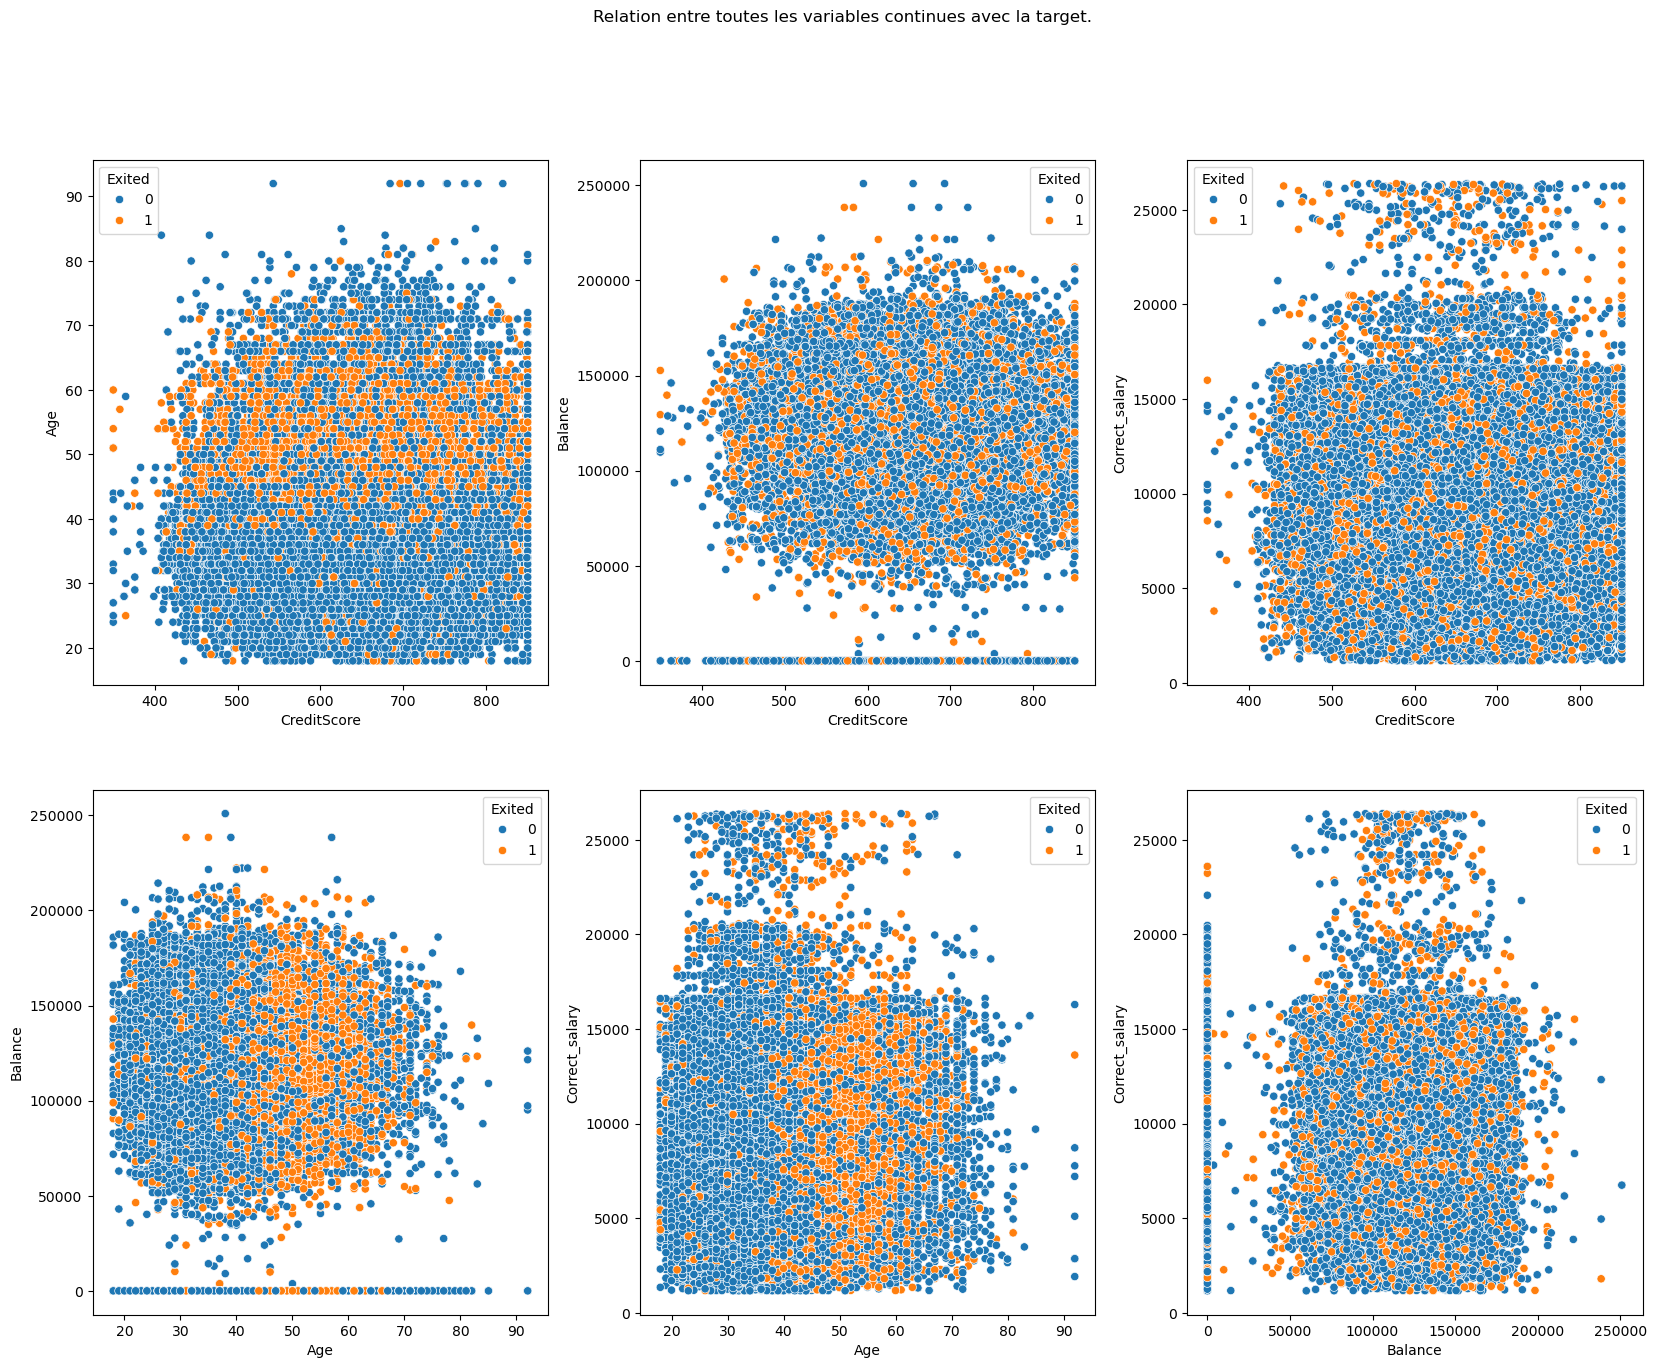

In [638]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
plt.suptitle("Relation entre toutes les variables continues avec la target.")
sns.scatterplot(data = train_set, x="CreditScore", y="Age", hue="Exited", ax=ax[0, 0])
sns.scatterplot(data = train_set, x="CreditScore", y="Balance", hue="Exited", ax=ax[0, 1])
sns.scatterplot(data = train_set, x="CreditScore", y="Correct_salary", hue="Exited", ax=ax[0, 2])
sns.scatterplot(data = train_set, x="Age", y="Balance", hue="Exited", ax=ax[1, 0])
sns.scatterplot(data = train_set, x="Age", y="Correct_salary", hue="Exited", ax=ax[1, 1])
sns.scatterplot(data = train_set, x="Balance", y="Correct_salary", hue="Exited", ax=ax[1, 2])
plt.show()

On ne voit aucune surface dans lequel on peut séparer totalement les deux classes de la target. On voit que beaucoup de clients qui ont résilié ont comme âge entre 40 et 70 ans. On doit donc visualiser les variables entre-eux.

#II.2.2) Analyse du score de crédits en fonction des variables discrétes.

#II.2.2.a) Analyse du score de crédit avec geography.

In [639]:
train_set.groupby("Geography")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,81886.0,655.943385,79.492249,350.0,597.0,660.0,710.0,850.0
Germany,30105.0,656.963694,81.173318,350.0,597.0,657.0,712.0,850.0
Spain,31588.0,657.099658,81.129352,350.0,598.0,660.0,711.0,850.0


On voit que les trois moyennes sont similaires et que les écart-types aussi. Faisons un test ANOVA.

In [640]:
print("H0: Les clients pour les trois pays de résidence ont en moyenne le même score de crédit.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Geography")["CreditScore"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour les trois pays de résidence ont en moyenne le même score de crédit.
Nous n'avons pas assez d'évidence pour rejeter H0.


Comme on n'a pas réussie à rejeter H0, on peut dire que les moyennes de score de crédit pour les trois pays sont les mêmes.

#II.2.2.b) Analyse du score de crédit en fonction du genre

In [641]:
train_set.groupby("Gender")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,62613.0,656.203792,80.592300,350.0,597.0,659.0,710.0,850.0
Male,80966.0,656.572487,79.913874,350.0,598.0,660.0,710.0,850.0


On voit que les deux moyennes sont vraiment trés proche et que l'écart-type aussi.

In [642]:
print("H0: Les hommes ont en moyennes le même score de crédit que les femmes.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Gender` == 'Male'")["CreditScore"], train_set.query("`Gender` == 'Female'")["CreditScore"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les hommes ont en moyennes le même score de crédit que les femmes.
Nous n'avons pas assez d'évidence pour rejeter H0.


On en conclut que les moyennes de score de crédit sont les mêmes ^pour les deux genres.

#II.2.2.c) Analyse du score de crédit en fonction de la tenure

In [643]:
train_set.groupby("Tenure")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
Tenure,,,,,,,,
0,4346.0,657.702945,81.186304,350.0,598.0,662.0,712.0,850.0
1,14603.0,655.619051,80.073639,350.0,596.0,659.0,710.0,850.0
2,15766.0,656.258785,80.809378,363.0,597.0,659.0,710.0,850.0
3,14484.0,656.150373,79.926995,350.0,598.0,659.0,711.0,850.0
4,15257.0,657.198007,79.754396,376.0,598.0,660.0,710.0,850.0
5,14984.0,655.392285,80.813767,363.0,597.0,659.0,711.0,850.0
6,13716.0,657.223389,81.123991,350.0,598.0,659.0,712.0,850.0
7,15474.0,656.292232,79.403599,350.0,598.0,659.0,710.0,850.0
8,15272.0,656.381221,79.330100,367.0,598.0,660.0,709.0,850.0


On voit que globalement les moyennes reste similaires et les écart-types aussi.

In [644]:
print("H0: Les clients pour toutes les tenures ont en moyenne le même score de crédit.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Tenure")["CreditScore"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour toutes les tenures ont en moyenne le même score de crédit.
Nous n'avons pas assez d'évidence pour rejeter H0.


Il n'y a donc pas d'évolution de la moyennes de scores de crédits en fonction de la tenure.

#II.2.2.d) Analyse du score de crédit en fonction du nombre de produit

In [645]:
train_set.groupby("NumOfProducts")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,67364.0,655.204798,80.540739,350.0,596.0,656.0,710.0,850.0
2,73301.0,657.573717,79.704863,350.0,599.0,662.0,710.0,850.0
3,2510.0,655.301992,84.661079,363.0,592.0,655.0,713.0,850.0
4,404.0,653.715347,85.057946,376.0,596.0,648.0,712.0,850.0


Les moyennes sont assez proche mais on voit que pour un nombre produit de 4, la moyennes s'éloigne un petit peu. Pour les écart-type c'est les clients qui ont un seul produit qui ont une moyenne assez différents. 

In [646]:
print("H0: Les clients pour tous les nombres de produits ont en moyenne le même score de crédit.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Tenure")["CreditScore"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour tous les nombres de produits ont en moyenne le même score de crédit.
Nous n'avons pas assez d'évidence pour rejeter H0.


Malgré les quelques différences, on ne peut pas affirmer que les moyennes pour les différents nombres de produit est significativement différent.

#II.2.2.e) Analyse du score de crédit en fonction du la possession d'une carte de crédit

In [647]:
train_set.groupby("HasCrCard")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0.0,35305.0,657.052627,82.897170,350.0,597.0,661.0,712.0,850.0
1.0,108274.0,656.202717,79.313868,350.0,598.0,659.0,710.0,850.0


Les deux moyennes sont similaires ainsi que les écart-types.

In [648]:
print("H0: Les clients qui ont une carte de crédit ont en moyennes le même score de crédit que les clients qui n'en n'ont pas.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`HasCrCard` == 0")["CreditScore"], train_set.query("`HasCrCard` == 1")["CreditScore"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont une carte de crédit ont en moyennes le même score de crédit que les clients qui n'en n'ont pas.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut dire qu'il n'y a pas de différences entre les deux moyennes.

#II.2.2.f) Analyse du score de crédit en fonction du status d'activité

In [649]:
train_set.groupby("IsActiveMember")["CreditScore"].describe()

,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0.0,72249.0,655.299727,80.198669,350.0,597.0,658.0,710.0,850.0
1.0,71330.0,657.538006,80.207051,350.0,598.0,661.0,711.0,850.0


Les deux moyennes sont similaires ainsi que les écart-types.

In [650]:
print("H0: Les clients actif ont en moyennes le même score de crédit que les clients inactif.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`IsActiveMember` == 0")["CreditScore"], train_set.query("`IsActiveMember` == 1")["CreditScore"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients actif ont en moyennes le même score de crédit que les clients inactif.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de se trompé de 2% que les deux moyennes sont significativement différentes. On peut don affirmer avec confiance que les personnes actif sont en moyenne plus fiable que les clients qui inactif. Comme on a vue qu'il y avait plus de clients qui ont résilié inzctif que actifs, on peut poser l'hypothése que la différences entre les deux moyennes du status d'activité est surement due au fait qu'il y a plus de client qui ont résilié qui sont inactif que actif. On peut dire que le score de crédit dépends uniquement du status d'activité.

#II.2.3) Analyse de l'âge en fonction des variables discrétes.

#II.2.3.a) Analyse de l'âge en fonction du pays de résidence.

In [651]:
train_set.groupby("Geography")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,81886.0,37.627170,8.672968,18.0,32.0,37.0,41.0,92.0
Germany,30105.0,39.755223,9.149116,18.0,33.0,39.0,45.0,83.0
Spain,31588.0,37.950372,8.932131,18.0,32.0,37.0,42.0,92.0


La moyenne pour l'Allemagne est relativement différentes par rapport au deux autres pays. On voit que l'âge moyen pour l'Allemagne est plus élevé que pour les autres pays.

In [652]:
print("H0: Les clients pour tous les pays ont en moyenne le âge.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Geography")["Age"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour tous les pays ont en moyenne le âge.
Nous avons assez d'évidence pour rejeter H0


On peut donc dire avec un risque de se trompé de 2% que en moyenne les clients qui vive en Allemagne sont plus vieux que pou les deux autre pays.

#II.2.3.b) Analyse de l'âge en fonction du genre.

In [653]:
train_set.groupby("Gender")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,62613.0,38.790911,9.121629,18.0,33.0,38.0,44.0,92.0
Male,80966.0,37.644572,8.640465,18.0,32.0,37.0,41.0,92.0


On voit que ne moyenne les femmes sont plus ^gées que les hommes mais de peu.

In [654]:
print("H0: Les femmes ont en moyennes le même âge que les hommes.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Gender` == 'Male'")["Age"], train_set.query("`Gender` == 'Female'")["Age"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les femmes ont en moyennes le même âge que les hommes.
Nous avons assez d'évidence pour rejeter H0


On peut donc dire avec un risque de 2% de se trompé que les femmes sont en moyennes plus âgé que les hommes.

#II.2.3.c) Analyse de l'âge en fonction de la tenure.

In [655]:
train_set.groupby("Tenure")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Tenure,,,,,,,,
0,4346.0,38.557294,9.005921,18.0,32.0,37.0,43.0,92.0
1,14603.0,38.472467,9.125987,18.0,32.0,37.0,43.0,92.0
2,15766.0,38.003806,8.737072,18.0,32.0,37.0,42.0,82.0
3,14484.0,38.214789,8.965872,18.0,32.0,37.0,43.0,92.0
4,15257.0,38.168120,8.806281,18.0,32.0,37.0,43.0,82.0
5,14984.0,38.257475,8.984538,18.0,32.0,37.0,43.0,81.0
6,13716.0,38.075241,8.825453,18.0,32.0,37.0,42.0,92.0
7,15474.0,37.790617,8.724207,18.0,32.0,37.0,42.0,84.0
8,15272.0,38.001594,8.739172,18.0,32.0,37.0,42.0,84.0


Il y a trés peu de différence entre les moyennes et les écart-types.

In [656]:
print("H0: Les clients pour toutes les tenures ont ont en moyenne le âge.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Tenure")["Age"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour toutes les tenures ont ont en moyenne le âge.
Nous avons assez d'évidence pour rejeter H0


On peut donc dire qu'il y a des différences entre les moyennes malgré des différences minime.

#II.2.3.d) Analyse de l'âge en fonction du nombre de produit

In [657]:
train_set.groupby("NumOfProducts")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,67364.0,39.472024,9.232956,18.0,33.0,38.0,45.0,92.0
2,73301.0,36.699818,8.209471,18.0,31.0,36.0,40.0,92.0
3,2510.0,43.681673,9.362345,18.0,37.0,44.0,50.0,77.0
4,404.0,44.500000,9.065381,22.0,39.0,44.0,50.0,82.0


On observe que les clients qui ont 3 et 4 produit sont en moyennes les clients les plus âgé et que les clients qui ont un seul produit sont en moyennes plus âgé que ceux qui en ont que deux.

In [658]:
print("H0: Les clients pour tous les nombres de produits ont en moyenne le même âge.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("NumOfProducts")["Age"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour tous les nombres de produits ont en moyenne le même âge.
Nous avons assez d'évidence pour rejeter H0


On peut donc dire avec un risque de 2% de se trompé que les clients qui ont 3 et 4 produit sont en moyennes plus âgé qu ceux qui ont 1 et 2 produits et que ceux qui ont un seul produit sont en moyennes plu âgé que ceux qui ont 2 produits.

#II.2.3.e) Analyse de l'âge en fonction de la possession d'une carte de crédit.

In [659]:
train_set.groupby("HasCrCard")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0.0,35305.0,38.336056,9.029089,18.0,32.0,37.0,43.0,92.0
1.0,108274.0,38.082008,8.818930,18.0,32.0,37.0,42.0,92.0


Les deux moyennes sont vraiment trés proche ainsi que les écart-types.

In [660]:
print("H0: Les clients qui ont une carte de crédit ont en moyenne le même âge que les personnes qui n'ont pas de carte de crédit.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`HasCrCard` == 0")["Age"], train_set.query("`HasCrCard` == 1")["Age"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont une carte de crédit ont en moyenne le même âge que les personnes qui n'ont pas de carte de crédit.
Nous avons assez d'évidence pour rejeter H0


On peut dire avec un risque de 2% de se trompé que les clients qui n'ont pas de carte de crédit sont en moyennes plus âgé que les clients qui ont une carte de crédit.

#II.2.3.f) Analyse de l'âge en fonction du status d'activité.

In [661]:
train_set.groupby("IsActiveMember")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0.0,72249.0,38.103356,8.237666,18.0,33.0,37.0,43.0,92.0
1.0,71330.0,38.186127,9.470628,18.0,32.0,37.0,42.0,92.0


Les deux moyennes sont vraiment trés proches.

In [662]:
print("H0: Les clients qui sont actif ont en moyenne le même âge que les personnes qui ne sont pas actifs.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`IsActiveMember` == 0")["Age"], train_set.query("`IsActiveMember` == 1")["Age"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui sont actif ont en moyenne le même âge que les personnes qui ne sont pas actifs.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut donc dire que les clients actif ont en moyenne le même âge que les clients inactifs. L'âge est donc relié à toutes les variables discrétes sauf le status d'activité.

#II.2.4) Analyse de la Balance en fonction des variable discrétes

#II.2.4.a) Analyse de la balance en fonction du pays de résidence.

Cette fois-ci comme la balance ne suit pas une loi normale on regardera directement les moyennes et les répartitions pour essayer de conclure.

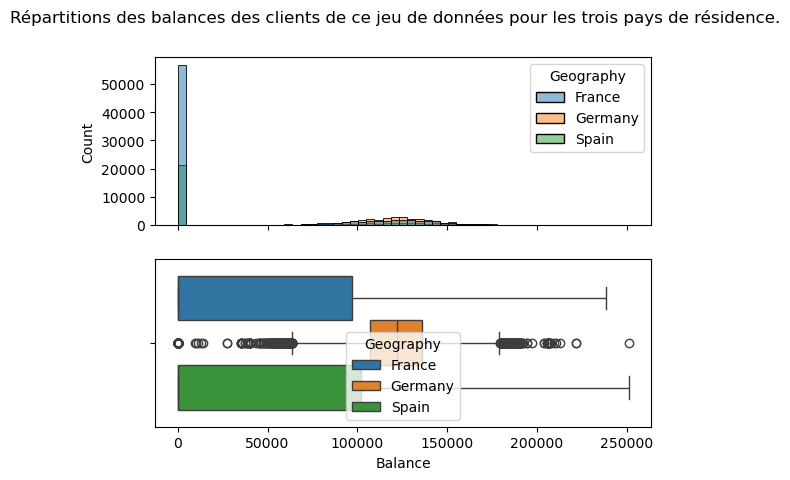

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,81886.0,37376.680784,57993.838054,0.0,0.00,0.00,96863.13,238387.56
Germany,30105.0,121234.034208,23223.945119,0.0,106970.61,122021.92,135776.36,250898.09
Spain,31588.0,39986.295655,59129.245732,0.0,0.00,0.00,101854.19,250898.09


In [663]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour les trois pays de résidence.")
sns.histplot(data=train_set, x="Balance", hue = "Geography", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "Geography", ax=ax[1])
plt.show()
train_set.groupby("Geography")["Balance"].describe()

On observe qu'il y trés peu de clients qui ont une balance égale à 0 pour les clients qui vive en Allemagne. On voit aussi une différence entre les clients qui vive dans les deux autres pays car on voit que la différences de clients entre ceux qui ont une balance différent de 0 et ceux qui ont une balance égale à 0 est pus grande chez les clients qui vive en France qu'en Espagne. On peut donc dire qu'il y a bien une influence du pays de résidence sur la balance des clients.

#II.2.4.b) Analyse de la Balance en fonction du genre

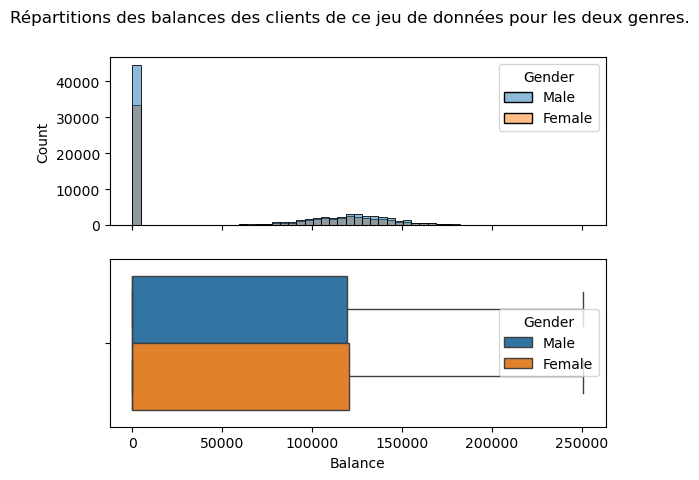

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,62613.0,56664.542237,62859.970451,0.0,0.0,0.0,120596.93,250898.09
Male,80966.0,54659.086612,62780.135461,0.0,0.0,0.0,119565.92,250898.09


In [664]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour les deux genres.")
sns.histplot(data=train_set, x="Balance", hue = "Gender", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "Gender", ax=ax[1])
plt.show()
train_set.groupby("Gender")["Balance"].describe()

Les moyennes sont presque identiques et il y a une superposition totale des deux groupes. Comme on ne peut pas faire de test d'hypothése, on va donc faire un test sur les balances différent de 0.

In [665]:
train_set.query("`Balance` != 0").groupby("Gender")["Balance"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,29249.0,121301.137922,24860.784857,3768.69,105229.730,121898.82,137712.0100,250898.09
Male,36412.0,121540.360502,25201.997391,3768.69,104974.615,122394.00,137847.4375,250898.09


On voit que les deux moyennes sont presque identiques.

In [666]:
print("H0: Les hommes qui ont une balance différent de 0 ont en moyennes la même balance que les femmes..")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Gender` == 'Male' and `Balance` != 0")["Balance"], train_set.query("`Gender` == 'Female' and `Balance` != 0")["Balance"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les hommes qui ont une balance différent de 0 ont en moyennes la même balance que les femmes..
Nous n'avons pas assez d'évidence pour rejeter H0.


On en conclut qu'il n'y a pas de différence de moyennes de balances entre les genres.

#II.2.4.c) Analyse de la Balance en fonction de la tenure

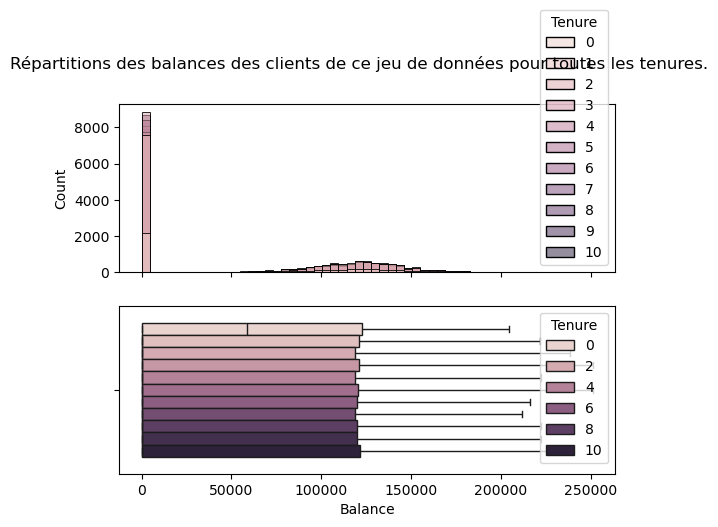

,count,mean,std,min,25%,50%,75%,max
Tenure,,,,,,,,
0,4346.0,61620.944374,63521.365190,0.0,0.0,58730.875,122501.2800,204223.03
1,14603.0,57942.720429,62632.866495,0.0,0.0,0.000,120919.1350,221532.80
2,15766.0,53499.763121,62748.830043,0.0,0.0,0.000,118627.1600,238387.56
3,14484.0,56454.191137,62904.859002,0.0,0.0,0.000,121093.5050,250898.09
4,15257.0,54491.244333,62529.531583,0.0,0.0,0.000,118840.0200,222267.63
5,14984.0,56051.448398,62970.741222,0.0,0.0,0.000,120152.1400,250898.09
6,13716.0,55155.146150,62871.806646,0.0,0.0,0.000,119714.2500,216109.88
7,15474.0,53337.806178,62630.665720,0.0,0.0,0.000,118502.4975,211774.31
8,15272.0,54837.753587,62844.216047,0.0,0.0,0.000,119951.1400,222267.63


In [667]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour toutes les tenures.")
sns.histplot(data=train_set, x="Balance", hue = "Tenure", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "Tenure", ax=ax[1])
plt.show()
train_set.groupby("Tenure")["Balance"].describe()

On observe des moyennes assez différentes pour une tenure de 0, 1 et 10 et donc il y a bien une différence visible. On voit aussi que pour beaucoup de valeurs la balance ne change pas beaucoup en moyenne.

#II.2.4.d) Analyse de la Balance en fonction du nombre de produit

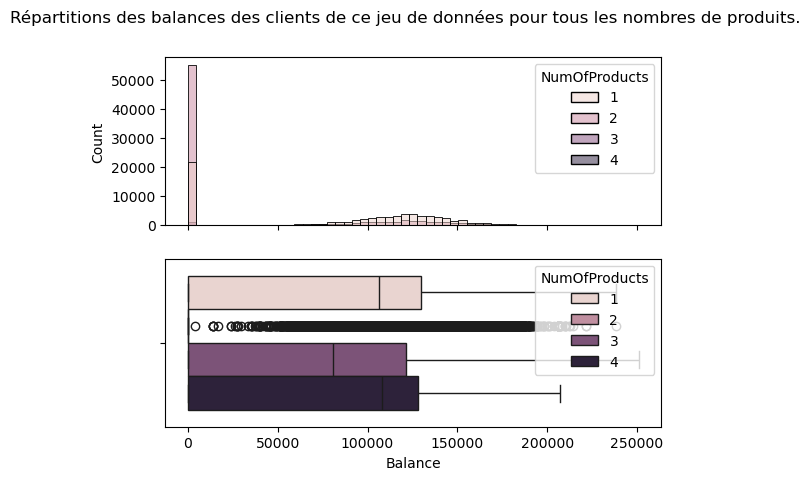

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,67364.0,82652.962902,60344.601045,0.0,0.0,106506.635,129938.0700,238387.56
2,73301.0,30166.695879,53865.394976,0.0,0.0,0.000,0.0000,238387.56
3,2510.0,64146.971586,63114.482883,0.0,0.0,80967.445,121678.8475,250898.09
4,404.0,82605.256064,60798.308151,0.0,0.0,107876.835,128356.2375,207034.96


In [668]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour tous les nombres de produits.")
sns.histplot(data=train_set, x="Balance", hue = "NumOfProducts", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "NumOfProducts", ax=ax[1])
plt.show()
train_set.groupby("NumOfProducts")["Balance"].describe()

On voit qu'il y a de trés grosse différence dans les moyennes. On voit que'il y a quasiment que des clients qui ont une balance égale à 0 pour les clients qui ont 2 produits.

#II.2.4.e) Analyse de la Balance en fonction du nombre de la possession d'une carte de crédit

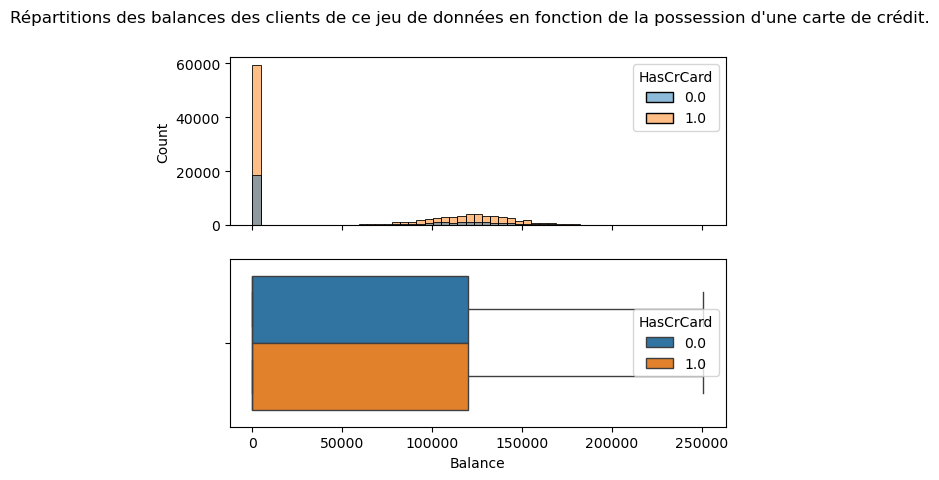

,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0.0,35305.0,57465.533311,62898.320767,0.0,0.0,0.0,119961.48,250898.09
1.0,108274.0,54903.706671,62785.351923,0.0,0.0,0.0,119948.09,250898.09


In [669]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données en fonction de la possession d'une carte de crédit.")
sns.histplot(data=train_set, x="Balance", hue = "HasCrCard", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "HasCrCard", ax=ax[1])
plt.show()
train_set.groupby("HasCrCard")["Balance"].describe()

On voit que les deux répartitions et moyennes sont assez similaires. On va donc faire un test sur les balance différent de 0.

In [670]:
train_set.query("`Balance` != 0").groupby("HasCrCard")["Balance"].describe()

,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0.0,16772.0,120964.742043,25424.820223,3768.69,103870.9825,121455.67,137740.455,250898.09
1.0,48889.0,121594.713251,24919.245779,3768.69,105525.7300,122453.97,137794.180,250898.09


Les moyennes sont assez simillaires.

In [671]:
print("H0: Les clients possédant une carte de crédit et qui ont une balance différent de 0 ont en moyennes la même balance que les clients qui n'ont pas carte de crédit.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`HasCrCard` == 0 and `Balance` != 0")["Balance"], train_set.query("`HasCrCard` == 1 and `Balance` != 0")["Balance"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients possédant une carte de crédit et qui ont une balance différent de 0 ont en moyennes la même balance que les clients qui n'ont pas carte de crédit.
Nous avons assez d'évidence pour rejeter H0


On peut dire avec un risque de se trompé de 2% que les clients possédant une carte de crédit ont en moyenne une balance différent de 0 supérieur au clients qui n'en n'ont pas.

#II.2.4.f) Analyse de la Balance en fonction du status d'activité

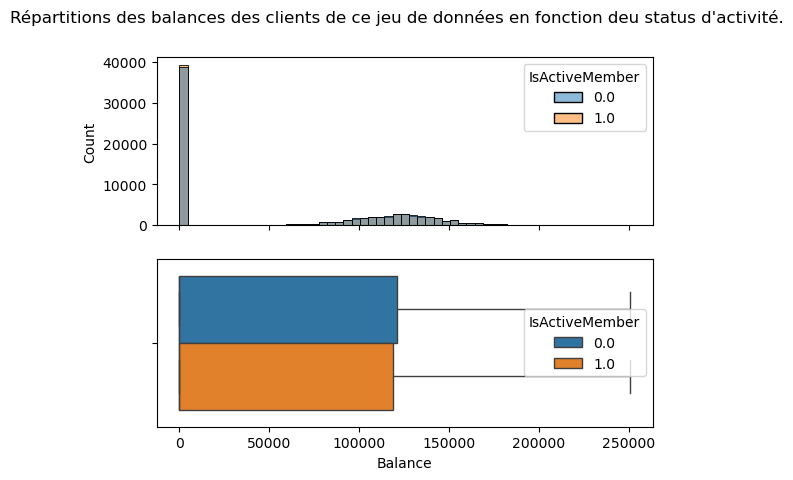

,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0.0,72249.0,56398.794272,62888.942088,0.0,0.0,0.0,120799.8200,250898.09
1.0,71330.0,54657.340563,62743.645575,0.0,0.0,0.0,118958.1775,250898.09


In [672]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données en fonction deu status d'activité.")
sns.histplot(data=train_set, x="Balance", hue = "IsActiveMember", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "IsActiveMember", ax=ax[1])
plt.show()
train_set.groupby("IsActiveMember")["Balance"].describe()

Il y a pratiquement aucune différence dans les répartitions et dans les moyennes. Regardons les balances différents de 0.

In [673]:
train_set.query("`Balance` != 0").groupby("IsActiveMember")["Balance"].describe()

,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0.0,33544.0,121474.972792,24765.323598,3768.69,105229.53,122321.91,137688.71,250898.09
1.0,32117.0,121390.793111,25345.576921,3768.69,105102.50,122214.00,137930.59,250898.09


On deux moyennes qui sont vraiment trés proches.

In [674]:
print("H0: Les clients actifs et qui ont une balance différent de 0 ont en moyennes la même balance que les clients inactifs.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`IsActiveMember` == 0 and `Balance` != 0")["Balance"], train_set.query("`IsActiveMember` == 1 and `Balance` != 0")["Balance"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients actifs et qui ont une balance différent de 0 ont en moyennes la même balance que les clients inactifs.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut dire qu'il n'y a pas de différence notable de la balance en fonction du status d'activité. En conclusion, il y a des différences dans la moyennes des balances pour les cas du pays de résidence, Tenure, nombre de produit et une différences partielles pour le cas de la possession d'une carte de crédit.

#II.2.5) Analyse du salaire en fonction des variables discrétes.

#II.2.5.a) Analyse deu salaire en fonction du pays de résidence

In [675]:
train_set.groupby("Geography")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,81886.0,9848.085610,3878.457068,1709.070833,6714.620000,10123.758333,13169.726667,20477.0665
Germany,30105.0,10215.424865,4123.063494,2007.161400,6923.928333,10322.666667,13472.595833,26389.9200
Spain,31588.0,9556.760836,3943.959176,1166.573333,6459.568125,9948.118333,12826.268333,16666.0400


On voit que en moyenne le salaire le moins élevé est pour les clients qui vivent en Espagne et que ne moyenne le salaire le plus grand est pour les clients qui vive en Allemagne.

In [676]:
print("H0: Les clients pour tous les pays ont en moyenne le même salaire.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Geography")["Correct_salary"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour tous les pays ont en moyenne le même salaire.
Nous avons assez d'évidence pour rejeter H0


On peut dire avec un risque de ce trompé de 2% que en moyennes les clietns qui vive en Allemagne ont les plus salaires et ceux qui ont le plus petit salaire sont les clients qui vive en Espagne.

#II.2.6.b) Analyse du salaire en fonction du genre

In [677]:
train_set.groupby("Gender")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,62613.0,9909.729888,3957.657536,1166.573333,6735.251667,10155.5725,13247.904167,26389.92
Male,80966.0,9823.342485,3945.840615,1166.573333,6677.551458,10095.9850,13130.427083,26389.92


On voit que les femmes ont en moyennes un plus gros salaire que les hommes.

In [678]:
print("H0: Les hommes ont en moyennes le même salaire que les femmes.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Gender` == 'Male'")["Correct_salary"], train_set.query("`Gender` == 'Female'")["Correct_salary"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les hommes ont en moyennes le même salaire que les femmes.
Nous avons assez d'évidence pour rejeter H0


On peut donc dire avec un risque de ce trompé de 2% que les femmes ont en moyennes un plus gros salaire que les hommes.

#II.2.6.c) Analyse du salaire en fonction de la tenure

In [679]:
train_set.groupby("Tenure")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
Tenure,,,,,,,,
0,4346.0,9961.313512,4027.410730,1173.470000,6681.790833,10139.185833,13404.329792,26260.98
1,14603.0,9810.443497,3952.133339,1173.593333,6659.996667,10069.235000,13122.696250,26389.92
2,15766.0,9844.663454,3970.576517,1172.824167,6659.930625,10104.222917,13210.917500,26389.92
3,14484.0,9821.116212,3965.114933,1172.759167,6677.902500,10100.840833,13157.655000,26387.71
4,15257.0,9897.551091,3949.287895,1173.330000,6770.840833,10207.382500,13169.748333,26342.33
5,14984.0,9818.620170,3933.491986,1166.573333,6681.465625,10074.422500,13130.614167,26362.40
6,13716.0,9912.201536,3948.641981,1169.385000,6800.199583,10149.809167,13210.650417,26387.57
7,15474.0,9874.901621,3950.897506,1172.809167,6681.545000,10129.266667,13260.777500,26342.33
8,15272.0,9913.734145,3936.595177,1172.759167,6791.377675,10154.768550,13217.792083,26342.37


On observe que les moyennes sont relativement constant.

In [680]:
print("H0: Les clients pour toutes les tenures ont en moyenne le même salaire.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("Tenure")["Correct_salary"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour toutes les tenures ont en moyenne le même salaire.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut donc dire que la moyenne du salaire reste constant en fonction de la tenure.

#II.2.6.d) Analyse du salaire en fonction du nombre de produit

In [681]:
train_set.groupby("NumOfProducts")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,67364.0,9892.193258,3966.820515,1169.385000,6665.710250,10123.758333,13240.258333,26389.92
2,73301.0,9829.731420,3939.485549,1166.573333,6718.257500,10117.416667,13155.962500,26389.92
3,2510.0,9939.581627,3885.517069,1364.430000,6786.646458,10108.862500,13195.219167,26327.63
4,404.0,9850.162921,3839.154466,1922.330833,7033.703958,10160.658333,12907.936042,18732.84


On voit que le salaire reste en moyenne relativement constant en fonction du nombre de produit.

In [682]:
print("H0: Les clients pour toutes les nombres de produits ont en moyenne le même salaire.")

alpha = 0.02

p_value = f_oneway(*train_set.groupby("NumOfProducts")["Correct_salary"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients pour toutes les nombres de produits ont en moyenne le même salaire.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut dire que en moyenne le salaire est constant en fonction du nombre de produit.

#II.2.6.e) Analyse du salaire en fonction de la possession d'une carte de crédit

In [683]:
train_set.groupby("HasCrCard")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0.0,35305.0,9868.753815,3962.439979,1166.573333,6746.993333,10097.983333,13195.385833,26389.92
1.0,108274.0,9858.491528,3947.565196,1166.573333,6682.530000,10127.131250,13171.200833,26389.92


Les deux salaires moyens sont presque identiques.

In [684]:
print("H0: Les clients possédant une carte de crédit ont en moyenne le même salaire que ceux qui n'en posséde pas.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`HasCrCard` == 0")["Correct_salary"], train_set.query("`HasCrCard` == 1")["Correct_salary"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients possédant une carte de crédit ont en moyenne le même salaire que ceux qui n'en posséde pas.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut dire que les clients possédant une carte de crédit ont en moyenne le même salaire que ceux qui n'en posséde pas.

#II.2.6.f) Analyse du salaire en fonction du status d'activité

In [685]:
train_set.groupby("IsActiveMember")["Correct_salary"].describe()

,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0.0,72249.0,9877.826718,3939.329816,1172.759167,6783.833333,10123.758333,13192.830833,26387.71
1.0,71330.0,9843.986577,3963.175191,1166.573333,6655.560833,10116.877500,13170.825000,26389.92


Les deux moyennes sont relativement proche.

In [686]:
print("H0: Les clients actif ont en moyenne le même salaire les clients inactif.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`IsActiveMember` == 0")["Correct_salary"], train_set.query("`IsActiveMember` == 1")["Correct_salary"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients actif ont en moyenne le même salaire les clients inactif.
Nous n'avons pas assez d'évidence pour rejeter H0.


On peut dire que les clients actif ont en moyenne le même salaire les clients inactif. Il y a donc des influence du pays de résidence et du genre sur le salaire.

#III) Préprocéssing

#III.1) Nettoyage des données

Commençons par le nettoyage des données.

In [687]:
train_set.isna().value_counts()

ID     CustomerId  Surname  CreditScore  Geography  Gender  Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  Correct_salary
False  False       False    False        False      False   False  False   False    False          False      False           False            False   False             143579
Name: count, dtype: int64

On voit qu'il n'y a pas de valeur vide dans le jeu de train. Durant l'analyse précédente on n'a pas vue d'outliers vraiment significatifs. On va aussi nettoyer les variables inutiles.

In [688]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

X_train_set = train_set.drop("Exited", axis=1)
y_train_set = train_set["Exited"]

set_config(transform_output='pandas')

#III.2) Encoding

On voit qu'il y a trois variables à encoder qui sont le nom, le pays de résidence et le genre mais on va seulement encoder le pays de résidence et le genre car on supprimera le nom. La variable du genre est une variable binaire et le pays est une variable non ordinal et par conséquent on utilisera seulement un onehot encoder pour les deux variables. 

In [719]:
categorical_column = ["Geography", "Gender"]
encoder = ColumnTransformer(
    [
        ("Encoding_onehot", OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore"), categorical_column)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('Encoding_onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Geography', 'Gender'])],
                  verbose_feature_names_out=False)

In [720]:
X_train_set_copy = X_train_set.copy()
column_encoders = encoder.fit_transform(X_train_set_copy)
column_encoders

,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Correct_salary
0,0.0,0.0,1.0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,13433.800833
1,0.0,0.0,1.0,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,15118.274167
2,0.0,0.0,1.0,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,8405.211667
3,1.0,0.0,0.0,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,5097.037500
4,0.0,0.0,0.0,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,8644.818333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,1.0,0.0,1.0,97639,15759915,Onwumelu,559,45.0,3,111634.29,1,1.0,1.0,103349.74,8612.478333
143575,1.0,0.0,1.0,95939,15769974,Shih,597,41.0,10,119182.73,1,0.0,0.0,121299.14,10108.261667
143576,0.0,1.0,1.0,152315,15592028,Hsiao,576,31.0,6,127299.56,1,1.0,1.0,57569.89,4797.490833
143577,0.0,0.0,0.0,117952,15804009,Ch'ang,751,27.0,4,90721.11,1,0.0,0.0,84496.78,7041.398333


3. Feature engineering

3. Normalisation

In [691]:
normalizer = ColumnTransformer(
    [
        ("Standard", StandardScaler(), ["Geography_Germany", "Geography_Spain",	"Gender_Male", "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "Correct_salary"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)
normalizer

ColumnTransformer(transformers=[('Standard', StandardScaler(),
                                 ['Geography_Germany', 'Geography_Spain',
                                  'Gender_Male', 'CreditScore', 'Age', 'Tenure',
                                  'Balance', 'NumOfProducts', 'HasCrCard',
                                  'IsActiveMember', 'Correct_salary'])],
                  verbose_feature_names_out=False)

In [692]:
final_column = normalizer.fit_transform(column_encoders)
final_column

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Correct_salary
0,-0.515076,-0.531092,0.879389,-0.366683,-1.143467,0.705942,1.212313,-1.013133,0.571026,1.006421,0.904227
1,-0.515076,-0.531092,0.879389,-0.740701,-0.467158,-1.075308,-0.883978,0.815851,-1.751233,1.006421,1.330547
2,-0.515076,-0.531092,0.879389,0.842641,0.096433,0.705942,-0.883978,0.815851,0.571026,1.006421,-0.368446
3,1.941462,-0.531092,-1.137153,0.082138,2.012643,-0.006558,1.003521,2.644835,0.571026,-0.993620,-1.205703
4,-0.515076,-0.531092,-1.137153,-0.366683,-0.579876,-0.006558,-0.883978,0.815851,0.571026,1.006421,-0.307804
...,...,...,...,...,...,...,...,...,...,...,...
143574,1.941462,-0.531092,0.879389,-1.214457,0.772742,-0.719058,0.893004,-1.013133,0.571026,1.006421,-0.315989
143575,1.941462,-0.531092,0.879389,-0.740701,0.321870,1.774693,1.013159,-1.013133,-1.751233,-0.993620,0.062575
143576,-0.515076,1.882914,0.879389,-1.002514,-0.805313,0.349692,1.142362,-1.013133,0.571026,1.006421,-1.281515
143577,-0.515076,-0.531092,-1.137153,1.179257,-1.256186,-0.362808,0.560110,-1.013133,-1.751233,-0.993620,-0.713610


In [721]:
pipeline = make_pipeline(encoder, normalizer)
pipeline

/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoding_onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender'])],
                                   verbose_feature_names_out=False)),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('Standard', StandardScaler(),
                                                  ['Geography_Germany',
                                                   'Geography_Spain',
                                                   'Gender_Male', 'CreditScore',
                                                   'Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Correct_salary'])],
                                   verbose_feature_names_out=False))])

In [722]:
train_set_finale = pipeline.fit_transform(X_train_set)
train_set_finale

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Correct_salary
0,-0.515076,-0.531092,0.879389,-0.366683,-1.143467,0.705942,1.212313,-1.013133,0.571026,1.006421,0.904227
1,-0.515076,-0.531092,0.879389,-0.740701,-0.467158,-1.075308,-0.883978,0.815851,-1.751233,1.006421,1.330547
2,-0.515076,-0.531092,0.879389,0.842641,0.096433,0.705942,-0.883978,0.815851,0.571026,1.006421,-0.368446
3,1.941462,-0.531092,-1.137153,0.082138,2.012643,-0.006558,1.003521,2.644835,0.571026,-0.993620,-1.205703
4,-0.515076,-0.531092,-1.137153,-0.366683,-0.579876,-0.006558,-0.883978,0.815851,0.571026,1.006421,-0.307804
...,...,...,...,...,...,...,...,...,...,...,...
143574,1.941462,-0.531092,0.879389,-1.214457,0.772742,-0.719058,0.893004,-1.013133,0.571026,1.006421,-0.315989
143575,1.941462,-0.531092,0.879389,-0.740701,0.321870,1.774693,1.013159,-1.013133,-1.751233,-0.993620,0.062575
143576,-0.515076,1.882914,0.879389,-1.002514,-0.805313,0.349692,1.142362,-1.013133,0.571026,1.006421,-1.281515
143577,-0.515076,-0.531092,-1.137153,1.179257,-1.256186,-0.362808,0.560110,-1.013133,-1.751233,-0.993620,-0.713610


#III) Modélisation

On va tester les 3 modéles du cours et prendre le meilleur.
On va commencer par régréssion logistique.

In [695]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'splitter': ['best', 'random']
}

grisearch = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="f1")
grisearch.fit(train_set_finale, y_train_set)

/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3360 fits failed out of a total of 13440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3360 fits failed with the following error:
Traceback (most recent call last):
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/p

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 20, 30, 40, 50],
                         'max_features': [None, 'sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [696]:
print(grisearch.best_params_)
print(grisearch.best_score_)

{'criterion': 'log_loss', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'splitter': 'random'}
0.6272269165008146


In [723]:
test_set = pd.read_csv("test_data.csv")
test_set.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [724]:
test_set["Correct_salary"] = test_set["EstimatedSalary"] * correction_salary(test_set, 1709, 1166, 2200)
test_set

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Correct_salary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75,7652.562500
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95,7573.079167
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15,3981.429167
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84,6891.403333
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16,12657.263333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,24790,15697574,Lucchese,685,France,Male,35.0,4,0.00,2,1.0,1.0,175072.47,14589.372500
21451,152608,15682708,Tuan,648,Spain,Female,47.0,3,0.00,1,1.0,0.0,156680.71,13056.725833
21452,28134,15614215,Ebelegbulam,607,France,Female,32.0,3,0.00,2,1.0,1.0,173599.38,14466.615000
21453,123871,15587573,Manna,705,France,Female,56.0,0,0.00,1,1.0,0.0,161479.19,13456.599167


In [725]:
test_set_finale = pipeline.transform(test_set)
test_set_finale

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Correct_salary
0,-0.515076,-0.531092,-1.137153,-0.890308,1.674488,-1.075308,-0.883978,0.815851,0.571026,1.006421,-0.558932
1,-0.515076,-0.531092,0.879389,-0.628496,-1.594340,-1.075308,-0.883978,-1.013133,-1.751233,1.006421,-0.579048
2,1.941462,-0.531092,0.879389,-0.291880,0.660024,-1.431558,1.008780,-1.013133,0.571026,-0.993620,-1.488050
3,1.941462,-0.531092,0.879389,-0.678365,0.209151,-1.075308,1.503100,0.815851,0.571026,1.006421,-0.751572
4,-0.515076,-0.531092,0.879389,-0.142273,-0.805313,-0.362808,1.222775,-1.013133,0.571026,-0.993620,0.707695
...,...,...,...,...,...,...,...,...,...,...,...
21450,-0.515076,-0.531092,0.879389,0.356418,-0.354440,-0.362808,-0.883978,0.815851,0.571026,1.006421,1.196688
21451,-0.515076,1.882914,-1.137153,-0.104871,0.998179,-0.719058,-0.883978,-1.013133,0.571026,-0.993620,0.808794
21452,-0.515076,-0.531092,-1.137153,-0.616029,-0.692594,-0.719058,-0.883978,0.815851,0.571026,1.006421,1.165620
21453,-0.515076,-0.531092,-1.137153,0.605763,2.012643,-1.787808,-0.883978,-1.013133,0.571026,-0.993620,0.909997


In [726]:
best_model = grisearch.best_estimator_

ypred = best_model.predict(test_set_finale)
ypred

array([0, 0, 1, ..., 0, 1, 0])

In [727]:
results = pd.DataFrame(
    {
        "ID": test_set["ID"],
        "Exited": ypred
    }
)
results.set_index("ID")

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0
...,...
24790,0
152608,1
28134,0


In [728]:
results.to_csv("submission.csv")